In [2]:
class HMC_Machine:
    def __init__(self, L = 20, epsilon = 0.1, num_simu = 1000):
        '''
        U is the energy function,
        grad_U is the gradient of U, 
        L is the number of steps is L, 
        epsilon is the step size in leapfrog.
        '''
        from numpy.random import multivariate_normal as mvn
        from numpy.random import uniform as unif
        from copy import deepcopy
        
        #import numpy as np
        
        #self.np = np
        self.deepcopy = deepcopy
        self.mvn = mvn
        self.unif = unif
        self.L = L
        self.epsilon = epsilon
        self.num_simu = num_simu
        self.deepcopy = deepcopy
    def f2(self,x):
        return self.U(x)
    
    def HMC(self, U, grad_U, current_q, L, epsilon, num_simu):
        '''
        q is the position variable that you want to sample,
        current_q is the initial point,
        p is the momentum variable.
        Currently mass matrix is assumed to be identity matrix.
        '''
        import numpy as np
        if not grad_U or not U:
            return 'Wrong'
        self.U = U
        self.grad_U = grad_U
        self.L = L
        self.epsilon = epsilon
        self.num_simu = num_simu
        deepcopy = self.deepcopy
        #q = deepcopy(current_q)
        dim_q = len(current_q)
        trajectory = np.zeros((num_simu,dim_q))
        
        for sim in range(num_simu):
            q = deepcopy(current_q) + 0.0
            current_p = self.mvn(mean = [0]*dim_q, cov = np.identity(dim_q), size = 1).flatten()
            p = deepcopy(current_p) + 0.0
            p -= epsilon * grad_U(q) / 2 #half step update for momentum p
           
            for i in range(L-1):
                q += epsilon * p
                p -= epsilon * grad_U(q)
            q += epsilon * p
            p -= epsilon * grad_U(q) / 2
            #print(p,q)
            current_U = U(current_q)
            candidate_U = U(q)
            current_K = np.sum(current_p ** 2) / 2
            candidate_K = np.sum(p ** 2) / 2
            
            if self.unif(low = 0, high = 1) < np.exp(current_U + current_K - candidate_U - candidate_K):
                trajectory[sim,:] = deepcopy(q)
                current_q = deepcopy(q)
            else:
                trajectory[sim,:] =  deepcopy(current_q)  
        return trajectory

    def MCMC(self, U, current_x, num_simu):
        '''
        U is the negate of log likelihood function,
        current_x is the initial point.
        Here, the proposal function is chosen to be guassian distribution,
        so it is symmetric, which further leads to that we don't need to compute them
        in our accept probability.
        '''
        import numpy as np
        if not U: 
            return 'Wrong'
        self.num_simu = num_simu
        deepcopy = self.deepcopy
        dim_x = len(current_x)
        trajectory = np.zeros((num_simu,dim_x))
        for sim in range(num_simu):
            #x = deep.copy(current_x)
            #proposed_x = self.mvn(mean = [0]*dim_x, cov = np.identity(dim_x), size = 1).flatten()
            proposed_x = self.mvn(mean = current_x, cov = np.identity(dim_x), size = 1).flatten()
            if self.unif(low = 0, high = 1) < np.exp(U(current_x) - U(proposed_x)):
                trajectory[sim,:] = proposed_x
                current_x = deepcopy(proposed_x)
            else:
                trajectory[sim,:] = current_x
        return trajectory

In [3]:
#no deepcopy version
class HMC_Machine:
    def __init__(self, L = 20, epsilon = 0.1, num_simu = 1000):
        '''
        U is the energy function,
        grad_U is the gradient of U, 
        L is the number of steps is L, 
        epsilon is the step size in leapfrog.
        '''
        from numpy.random import multivariate_normal as mvn
        from numpy.random import uniform as unif
        from numpy.random import normal
        #from copy import deepcopy
        #import numpy as np
        #self.np = np
        self.mvn = mvn
        self.unif = unif
        self.L = L
        self.epsilon = epsilon
        self.num_simu = num_simu
        self.normal = normal

        
    def HMC(self, U, grad_U, current_q, L, epsilon, num_simu):
        '''
        q is the position variable that you want to sample,
        current_q is the initial point,
        p is the momentum variable.
        Currently mass matrix is assumed to be identity matrix.
        '''
        import numpy as np
        if not grad_U or not U:
            return 'Wrong'
        self.U = U
        self.grad_U = grad_U
        self.L = L
        self.epsilon = epsilon
        self.num_simu = num_simu
    
        dim_q = len(current_q)
        trajectory = np.zeros((num_simu,dim_q))
        current_q += 0.0
        p_initials = self.normal(0, 1, dim_q * num_simu).reshape(num_simu, dim_q)
        #np.dot()
        unif_numbers = self.unif(low = 0, high = 1, size = num_simu)
        count = 0.0
        
        for sim in range(num_simu):

            q = current_q + 0.0
            
            current_p = p_initials[sim,]
            p = current_p + 0.0
            
            p -= epsilon * grad_U(q) / 2 #half step update for momentum p
           
            for i in range(L-1):
                q += epsilon * p
                p -= epsilon * grad_U(q)
            q += epsilon * p
            p -= epsilon * grad_U(q) / 2
            
            current_U = U(current_q)
            candidate_U = U(q)
            current_K = np.sum(current_p ** 2) / 2
            candidate_K = np.sum(p ** 2) / 2
            
            tmp = np.exp(current_U + current_K - candidate_U - candidate_K)
            if math.isinf(tmp):
                print('inf number')
            if math.isnan(tmp):
                print('NaN number')
            if self.unif(low = 0, high = 1) < tmp:
                trajectory[sim,:] = q + 0.0
                current_q = q + 0.0
                count += 1
            else:
                trajectory[sim,:] = current_q 

        return trajectory, count / num_simu

    def MCMC(self, U, current_x, num_simu, scale):
        '''
        U is the negate of log likelihood function,
        current_x is the initial point.
        Here, the proposal function is chosen to be guassian distribution,
        so it is symmetric, which further leads to that we don't need to compute them
        in our accept probability.
        '''
        
        import numpy as np
        if not U: 
            return 'Wrong'
        self.num_simu = num_simu
        dim_x = len(current_x)
        trajectory = np.zeros((num_simu,dim_x))
        unif_numbers = self.unif(low = 0, high = 1, size = num_simu)
        count = 0.0
        
        for sim in range(num_simu):
            #proposed_x = self.mvn(mean = [0]*dim_x, cov = np.identity(dim_x), size = 1).flatten()
            #proposed_x = self.mvn(mean = current_x, cov = scale * np.identity(dim_x), size = 1).flatten()
            proposed_x = np.dot(scale * np.identity(dim_x), self.normal(0, 1, dim_x).reshape(dim_x, -1)) + current_x.reshape(dim_x, -1)
            
            #print(proposed_x.shape)
            if unif_numbers[sim] < np.exp(U(current_x) - U(proposed_x)):
                trajectory[sim,:] = proposed_x.flatten()
                current_x = proposed_x + 0.0
                count += 1
            else:
                trajectory[sim,:] = current_x.flatten()
        accept_rate = count / num_simu
        return trajectory, accept_rate
    

In [66]:
# u = np.array([2,1])
# cov = [[2, -2], [-2, 5]]
dim = 20
a = np.zeros((dim,dim));
a[~np.eye(a.shape[0],dtype=bool)] = -0.5
a[np.eye(a.shape[0],dtype=bool)] = np.array(range(dim)) + 10;a
cov = a
u = 10 + np.random.normal(0, 1, dim)


def negate_mvn_logpdf(x):
    import numpy as np
  # x, u are like (3,) or (3,1)
  # this function can fail in multiple ways
    k = len(u)               # scalar like 3
    uu = u.reshape(k, 1)     # like 3x1
    xx = x.reshape(k, 1)     # like 3x1

    t1 = (2 * np.pi)**k          # scalar
    t2 = np.linalg.det(cov)      # scalar
    t3 = 1.0 / np.sqrt(t1 * t2)  # scalar 

    t4 = (xx - uu).T          # shape like 1x3 
    t5 = np.linalg.inv(cov)   # like 3x3
    t6 = (xx - uu)            # like 3x1
    t7 = -0.5 * (np.dot(t4,t5).dot(t6))
    #             1x3  3x3     3x1 = 1x1
    result = t3 * np.exp(t7)  # 1x1
    
    result = np.exp(-0.5 * (np.dot((xx - uu).T, np.linalg.inv(cov)).dot((xx - uu)))) / np.sqrt(t1 * t2) # 1x1
    #print(result)
    #print(0.5 * (np.dot((xx - uu).T, np.linalg.inv(cov)).dot((xx - uu))) + k * np.log(2*np.pi) / 2.0 + np.log(np.linalg.det(cov))/2.0 )
    return 0.5 * (np.dot((xx - uu).T, np.linalg.inv(cov)).dot((xx - uu))) + k * np.log(2*np.pi) / 2.0 + np.log(np.linalg.det(cov))/2.0 
    #return -np.log(result[0][0])

def grad_negate_mvn_logpdf(x):
    import numpy as np
    k = len(u) 
    uu = u.reshape(k, 1)     # like 3x1
    xx = x.reshape(k, 1)     # like 3x1
    result = np.dot(np.linalg.inv(cov),(xx - uu))
    return result[0][0]

In [67]:
np.linalg.det(cov)

1.918726467815602e+25

In [68]:
import math
simulator = HMC_Machine()

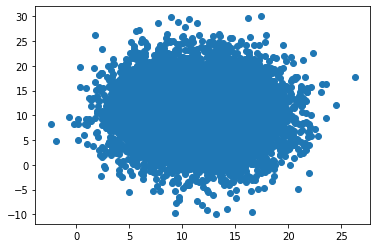

In [100]:
#x,y = np.random.multivariate_normal(u,cov,1000).T
samples = np.random.multivariate_normal(u,cov,10000)
import matplotlib.pyplot as plt
plt.scatter(samples[:,3], samples[:,19])
lx,ux = min(samples[:,3]), max(samples[:,3])
ly,uy = min(samples[:,19]), max(samples[:,19])
#plt.xlim([lx,ux])
#plt.ylim([ly,uy])
plt.show();

In [79]:
#init_point = u + np.random.normal(0, 5, dim)
#samples2 = simulator.MCMC(partial(negate_mvn_logpdf,u = np.array([1]), cov =  np.array([1])),init_point,num_simu=20000)



In [80]:
samples2.shape

(20000, 20)

In [81]:
init_point = u + np.random.normal(0, 5, dim)

In [97]:
samples2, accept_rate = simulator.MCMC(negate_mvn_logpdf,init_point,scale = 0.2, num_simu=10000)

In [98]:
accept_rate

0.925

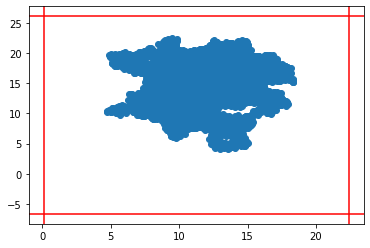

In [99]:
import matplotlib.pyplot as plt
plt.scatter(samples2[:,3], samples2[:,19])
# plt.xlim([lx,ux])
# plt.ylim([ly,uy])
plt.axvline(x=lx, color='r')
plt.axvline(x=ux, color='r')
plt.axhline(y=uy, color='r')
plt.axhline(y=ly, color='r')
plt.show();
#np.cov(samples2.T)

In [94]:
samples1,accept_rate = simulator.HMC(negate_mvn_logpdf,grad_negate_mvn_logpdf,init_point,L = 50, 
                                     epsilon = 0.02, num_simu=10000)

In [95]:
accept_rate

0.4682

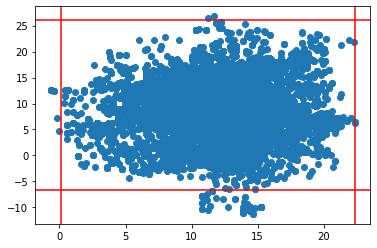

In [96]:
import matplotlib.pyplot as plt
plt.scatter(samples1[:,3], samples1[:,19])
# plt.xlim([lx,ux])
# plt.ylim([ly,uy])
plt.axvline(x=lx, color='r')
plt.axvline(x=ux, color='r')
plt.axhline(y=uy, color='r')
plt.axhline(y=ly, color='r')
plt.show();
#np.cov(samples1.T)

In [298]:
np.mean(samples1, axis = 0)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [299]:
np.mean(samples2, axis = 0)

array([ 0.99260991,  1.65787044,  2.61398059,  4.43291915,  4.85960658,
        6.20909874,  6.90660325,  7.60995398,  8.68426742, 10.27955134,
       10.77863702, 11.8649358 , 13.80373574, 14.60629137, 15.30205089,
       17.94490761, 16.41484968, 16.351949  , 19.08188559, 19.18777688,
       20.68297692, 21.88692973, 23.5601909 , 23.71783984, 26.59360784,
       24.29257145, 27.10949883, 29.34439587, 28.83670624, 29.71259656,
       31.9935705 , 32.46456355, 32.90434922, 34.41998044, 32.865883  ,
       35.30162033, 36.68699829, 35.04256852, 38.8734996 , 43.31997461,
       42.60335962, 44.01927914, 41.78902076, 44.98774806, 42.3417304 ,
       48.3298596 , 47.24516563, 49.10676636, 48.66384389, 49.30194522])

In [300]:
np.round(np.cov(samples1.T)[0:7,0:7],2)

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [301]:
np.round(np.cov(samples2.T)[0:7,0:7],3)

array([[10.573,  0.189, -0.222, -0.888, -2.156, -1.076, -1.738],
       [ 0.189,  7.985, -0.618, -0.53 , -1.173, -0.671, -0.115],
       [-0.222, -0.618, 13.246, -2.066, -0.955, -1.65 , -0.727],
       [-0.888, -0.53 , -2.066, 13.813, -1.157, -0.151,  0.471],
       [-2.156, -1.173, -0.955, -1.157, 16.148,  0.14 ,  0.136],
       [-1.076, -0.671, -1.65 , -0.151,  0.14 , 14.082, -1.598],
       [-1.738, -0.115, -0.727,  0.471,  0.136, -1.598, 13.185]])

In [295]:
cov[0:7,0:7]

array([[10. , -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, 11. , -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, 12. , -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, 13. , -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, 14. , -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, 15. , -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 16. ]])

In [133]:
import time
start_time = time.time()
for i in range(10):
    simulator.HMC(negate_mvn_logpdf,grad_negate_mvn_logpdf,np.ones(50),L = 20, epsilon = 0.025, num_simu=1000)
print("--- %s seconds ---" % (time.time() - start_time))

#without deepcopy

--- 47.67466592788696 seconds ---


In [126]:
import time
start_time = time.time()
for i in range(10):
    simulator.HMC(negate_mvn_logpdf,grad_negate_mvn_logpdf,np.ones(50),L = 20, epsilon = 0.025, num_simu=1000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 47.31628394126892 seconds ---


In [3]:
# def log_L(Z, u, V, Beta, alpha, sigma):
#     #compute full log likelihood of one sample
#     #debug finished
#     alpha = np.array(alpha).reshape((1, -1))
#     Beta = np.array(Beta).reshape((len(Beta), -1))
#     Z = np.array(Z).reshape((len(Z), -1))
#     u = np.array(u).reshape((1, -1))
#     V = np.array(V).reshape((len(V), -1))
#     k = len(Z)
#     tmp = np.dot(Z.T, Beta) + alpha   
    
#     result = tmp * (1 - u) - np.log(1 + np.exp(tmp)) - k * np.log(2 * np.pi) - k * np.log(sigma) - \
#             (0.5 * np.dot((Z - V).T, (Z - V)) / (sigma ** 2)) - 0.5 * np.dot(Z.T,Z)
    
#     return result

In [51]:
def log_L(Z, u, V, Beta, alpha, sigma):
    #compute full log likelihood of one sample
    #debug finished
    
    alpha = np.array(alpha).reshape((1, -1))
    Beta = np.array(Beta).reshape((len(Beta), -1))
    Z = np.array(Z).reshape((len(Z), -1))
    u = np.array(u).reshape((1, -1))
    V = np.array(V).reshape((len(V), -1))
    k = len(Z)
    tmp = np.dot(Z.T, Beta) + alpha   
    
    result = tmp * (1 - u) - np.log(1 + np.exp(tmp)) - k * np.log(2 * np.pi) - k * np.log(sigma) - \
            (0.5 * np.dot((Z - V).T, (Z - V)) / (sigma ** 2)) - 0.5 * np.dot(Z.T,Z)
    
    return result

def log_L_grad(Z, u, V, Beta, alpha, sigma):
    #compute full log likelihood gradient of one sample
    #debug finished
    
    alpha = np.array(alpha).reshape((1, -1))
    Beta = np.array(Beta).reshape((len(Beta), -1))
    Z = np.array(Z).reshape((len(Z), -1))
    u = np.array(u).reshape((1, -1))
    V = np.array(V).reshape((len(V), -1))
    k = len(Z)
    tmp = np.exp(np.dot(Z.T, Beta) + alpha)
    
    return np.concatenate(( (1 - u) - tmp/(1+tmp), ((1 - u) - tmp/(1+tmp)) * Z ))  
    
def log_L_Hessian(Z, u, V, Beta, alpha, sigma):
    #compute full log likelihood Hessian matrix of one sample
    #debug finished
    
    alpha = np.array(alpha).reshape((1, -1))
    Beta = np.array(Beta).reshape((len(Beta), -1))
    Z = np.array(Z).reshape((len(Z), -1))
    u = np.array(u).reshape((1, -1))
    V = np.array(V).reshape((len(V), -1))
    k = len(Z)
    
    ZZ = np.concatenate( (np.array(1).reshape((1, -1)), Z) )
    
    tmp = np.exp(np.dot(Z.T, Beta) + alpha) 
    
    return -np.dot(ZZ,ZZ.T) * ((tmp / (1 + tmp)) / (1 + tmp))    

In [52]:
from functools import partial
def Full_log_L(Zs, us, Vs, Beta, alpha, sigma):
    #input Zs is a n x p matrix
  
    #     a, b = Zs.shape
    #     if b != len(Beta):
    #         return 'error: dimension does not match'
    Zs = Zs.reshape((len(us), len(Beta)))
    map_Func = partial(log_L, Beta = Beta, alpha = alpha, sigma = sigma)
    #print(Zs.shape)
    result = list(map(map_Func, Zs, us, Vs))
    #print([i for i in result])
    return sum([i for i in result])

def Full_log_L_grad(Zs, us, Vs, Beta, alpha, sigma):
    Zs = Zs.reshape((len(us), len(Beta)))
    
    map_Func = partial(log_L_grad, Beta = Beta, alpha = alpha, sigma = sigma)
    result = list(map(map_Func, Zs, us, Vs))
    #print([i for i in result])
    return sum([i for i in result])

    
def Full_log_L_Hessian(Zs, us, Vs, Beta, alpha, sigma):
    
    map_Func = partial(log_L_Hessian, Beta = Beta, alpha = alpha, sigma = sigma)
    result = list(map(map_Func, Zs, us, Vs))
    #print([i for i in result])
    return sum([i for i in result])


In [53]:
def Z_2D_to_1D(Z):
    return np.array(Zs).flatten()

def Z_1D_to_2D(Z, num_row):
    return np.array(Zs).flatten().reshape((num_row, -1))

In [54]:

dim = 2
n = 200
mvn(mean = [0] * dim, cov = np.identity(dim), size = 1).flatten()

array([ 0.55131523, -0.73152773])

In [55]:
# simulation part
import numpy as np
from random import seed
from numpy.random import multivariate_normal as mvn
from numpy.random import binomial
seed(1234567890)
dim = 2
n = 200
sigma = 1
alpha = 0
Beta = np.array([1,2])
Z1 = mvn(mean = [0] * dim, cov = np.identity(dim), size = n) #Z_1 ... Z_n

In [56]:
P1 = [1.0/(1 + np.exp(alpha + np.dot(Z1[i,],Beta.reshape((dim,-1))))) for i in range(n)]
U1 = [binomial(n = 1, p = p_i, size = 1) for p_i in P1]
V1 = [mvn(mean = Z1[i,], cov = (sigma**2) * np.identity(dim), size = 1).flatten() for i in range(n)]

In [57]:
V1 = np.array(V1); U1 = np.array(U1);

In [58]:
simulator = HMC_Machine()
def U_function(Z, U, V, Beta, alpha, sigma):
    
    return -Full_log_L(Zs = Z, us = U, Vs = V, Beta = Beta, alpha = alpha, sigma = sigma)

def grad_U_function(Z, U, V, Beta, alpha, sigma):
    
    return -Full_log_L_grad(Zs = Z, us = U, Vs = V, Beta = Beta, alpha = alpha, sigma = sigma)

In [59]:
#(self, U, current_x, num_simu)
simulator.MCMC(U = partial(U_function, U = U1, V = V1, Beta = Beta, alpha = alpha, sigma = sigma), current_x = np.zeros(dim * n), num_simu=100)





array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
simulator.HMC(U = partial(U_function, U = U1, V = V1, Beta = Beta, alpha = alpha, sigma = sigma), 
              grad_U = partial(grad_U_function, U = U1, V = V1, Beta = Beta, alpha = alpha, sigma = sigma), \
               current_q = np.zeros(dim * n), L = 10, epsilon = 0.1, num_simu=10)
              



(400,) (3, 1)


ValueError: non-broadcastable output operand with shape (400,) doesn't match the broadcast shape (3,400)

In [ ]:
HMC(self, U, grad_U, current_q, L, epsilon, num_simu):

In [101]:
def U_function(Z, U, V, Beta, alpha, sigma):
    
    return -Full_log_L(Zs = Z, us = U, Vs = V, Beta = Beta, alpha = alpha, sigma = sigma)

def grad_U_function(Z, U, V, Beta, alpha, sigma):
    #Z: n x p
    #U: n x 1
    #Beta: p x 1
    
    #debug finished
    
    #the n x p matrxi:
    tmp = np.dot(-U, Beta.T) + np.dot( 1.0 /(1 + np.exp(np.dot(Z, Beta) + alpha)), Beta.T) + \
        V / (sigma**2) - Z - Z  / (sigma**2)
    
    print(V / (sigma**2) - Z - Z  / (sigma**2))
    return tmp.flatten()

In [99]:
Zs = np.array([[0.5, -0.5], [0.4, -0.3]])
us = np.array([0, 1]).reshape((2,1))
Vs = np.array([[0.7, -0.6], [0.4, -0.3]])
sigma = 1
alpha = 0.2
Beta = np.array([1,2]).reshape((2,1))

In [100]:
grad_U_function(Zs, us, Vs, Beta, alpha, sigma)

[[-0.3  0.4]
 [-0.4  0.3]]


array([ 0.27444252,  1.54888503, -0.9       , -0.7       ])

In [90]:
0.2744425 1.5488850

SyntaxError: invalid syntax (<ipython-input-90-9ee956484522>, line 1)

In [85]:
np.dot(Beta.T,Zs[0,])

array([-0.5])

In [944]:
U_functiFull_log_L_gradon(Z, U, V, Beta, alpha, sigma)

array([[ 0.16237422],
       [ 0.10879221],
       [-0.17320413]])

In [ ]:
simulator.MCMC(U_function)

In [70]:
a = np.array(list(range(10)));a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [73]:
a.flatten().reshape((5,2)).flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [773]:
np.array(Zs).flatten().reshape((2, -1))

array([[ 0.5 , -0.5 ],
       [ 0.44, -0.3 ]])

In [774]:
Zs = [[0.5, -0.5], [0.44, -0.3]]
us = [0, 1]
Vs =[[0.7, -0.6], [0.4334, -0.323]]

In [754]:
s = Full_log_L(np.array(Zs), us, Vs, Beta = [1,2], alpha = 0.3, sigma = 0.2)

[array([[-2.13001718]]), array([[-1.37143049]])]


array([[ 0.5 , -0.5 ],
       [ 0.44, -0.3 ]])

In [750]:
Full_log_L_grad(Zs, us, Vs, Beta = [1,2], alpha = 0.3, sigma = 0.2)

[array([[ 0.549834],
       [ 0.274917],
       [-0.274917]]), array([[-0.53494295],
       [-0.2353749 ],
       [ 0.16048288]])]


array([[ 0.01489105],
       [ 0.0395421 ],
       [-0.11443412]])

In [658]:
from functools import partial
#for Zs, us, Vs each element(row) is a sample Z_i
#Zs, us, Vs could be np.array or list
map_Full_logL_over_Z = partial(Full_log_L, u = [0,1], V = [[0.7, -0.6], [0.4334, -0.323]], Beta = [1,2], alpha = 0.3, sigma = 0.2)
result = map(map_Full_log_L, Zs)


In [ ]:
from functools import partial
#for Zs, us, Vs each element(row) is a sample Z_i
#Zs, us, Vs could be np.array or list
map_Full_log_L = partial(Full_log_L, Beta = [1,2], alpha = 0.3, sigma = 0.2)
result = map(map_Full_log_L, Zs, us, Vs)



In [693]:
Zs = [[0.5, -0.5], [0.44, -0.3]]
us = [0, 1]
Vs =[[0.7, -0.6], [0.4334, -0.323]]
from functools import partial
mapfunc = partial(log_L, Beta = [1,2], alpha = 0.3, sigma = 0.2)
result = map(mapfunc, Zs, us, Vs)
sum([i[0][0] for i in result])

-3.501447667619723

In [74]:
np.array([1,0,1]) * np.array([3.5,4.5])

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [642]:
Full_log_L_Hessian([1,2],0.3,[0.5,-0.5],0,[0.7,-0.6],0.2)

In [ ]:
Full_log_L_grad([1,2],0.3,[0.5,-0.5],0,[0.7,-0.6],0.2)

In [546]:
a = -Full_log_L_Hessian([1,2],0.3,[0.5,-0.5],0,[0.7,-0.6],0.2) - \
Full_log_L_Hessian([1,2],0.3,[0.55,-0.55],0,[0.7,-0.6],0.2)

In [394]:
np.concatenate((np.array([1,23]),1))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [533]:
np.concatenate((a.reshape((2,1)),np.array(3).reshape(1,1)))

array([[1],
       [2],
       [3]])

In [664]:
a = np.array([1,2]);a + 2
c,d = a.shape

ValueError: not enough values to unpack (expected 2, got 1)

In [529]:
a.reshape((1,2)).T

array([[1],
       [2]])

In [429]:
np.concatenate((a.reshape((2,-1)),np.array(3).reshape(1,-1))).shape

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

In [424]:
a = a.reshape([2,1])

In [425]:
a

array([[1],
       [2]])

In [450]:
np.concatenate((a.reshape((2,-1)),c).shape

(3, 1)

In [440]:
np.array([3])

array([3])

In [452]:
len(a.reshape((2,-1)))

2

In [454]:
x = a.reshape((2,-1))
y = np.array(3).reshape(1,-1)

In [458]:
np.concatenate((x,y))

array([[1],
       [2],
       [3]])

In [463]:
Z = [1,2,3]

In [464]:
Z = np.array(Z);Z

array([1, 2, 3])

In [465]:
Z = np.array(Z);Z

array([1, 2, 3])

In [481]:
np.linalg.det(np.diag([1]*5)*2)

32.0

In [480]:
np.diag([1]*5)*2

array([[2, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 2]])

In [488]:
x = 1 + 3 + \
4

In [489]:
x

8

In [551]:
def sentence( x, y):
    return " this string contains %s and %s" % (x,y)
matrix = [['a','b'],['c','d']]

output = map(lambda a: sentence(a[0],a[1]), matrix)

# Print the top level
for i in output:
    print(i)

 this string contains a and b
 this string contains c and d


In [ ]:
#抽出来的样本每一行都包含了 n 个 p 维（np x 1）的 hidden variable
#需要把这一行变成 n x p 的矩阵再feed 进似然函数